In [5]:
#绘图字体和配色
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 16

class AcademicColors:
    """
    学术严谨风格配色方案
    基于Nature、Science等顶级科学期刊的设计理念
    """

    def __init__(self):
        # 主色板
        self.primary = '#333333'
        self.secondary = '#000000'
        self.background = '#F0F0F0'
        self.gridline = '#D9D9D9'

        # 分类色板（图表专用）
        self.categorical = [
            '#FF8C00',  # 明亮橙色 (保留)
            '#6A7FDB',  # 明亮靛蓝 (保留)
            '#2E8B7A',  # 深青 (保留)
            '#A0522D',  # 深红棕色 (替换金色)
            '#DA70D6',  # 明亮兰花紫 (保留)
            '#87CEEB',  # 天蓝色 (保留)
        ]

        # 发散色板
        self.diverging = [
            '#053061',  # 深蓝
            '#67A9CF',  # 浅蓝
            '#F7F7F7',  # 中性灰
            '#EF8A62',  # 浅红
            '#B2182B'   # 深红
        ]

        # 创建颜色映射
        self.categorical_cmap = ListedColormap(self.categorical)
        self.diverging_cmap = ListedColormap(self.diverging)

    def set_style(self):
        """设置matplotlib和seaborn的学术风格"""
        # 设置seaborn样式
        sns.set_style("whitegrid", {
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.5,
            "grid.color": self.gridline,
            "axes.edgecolor": self.secondary,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.top": False,
            "axes.spines.right": False,
        })

        # 设置matplotlib参数
        plt.rcParams.update({
            'font.size': 10,
            'axes.titlesize': 12,
            'axes.labelsize': 10,
            'xtick.labelsize': 9,
            'ytick.labelsize': 9,
            'legend.fontsize': 9,
            'figure.titlesize': 14,
            'axes.titlecolor': self.secondary,
            'axes.labelcolor': self.primary,
            'text.color': self.primary,
            'axes.edgecolor': self.secondary,
            'xtick.color': self.primary,
            'ytick.color': self.primary,
            'grid.alpha': 0.6,
            'axes.axisbelow': True
        })

        # 设置默认调色板
        sns.set_palette(self.categorical)

    def get_colors(self, n=None, palette_type='categorical'):
        """
        获取指定数量的颜色

        Parameters:
        -----------
        n : int, optional
            需要的颜色数量，如果为None则返回完整调色板
        palette_type : str
            调色板类型，'categorical' 或 'diverging'

        Returns:
        --------
        list : 颜色列表
        """
        if palette_type == 'categorical':
            colors = self.categorical
        elif palette_type == 'diverging':
            colors = self.diverging
        else:
            raise ValueError("palette_type must be 'categorical' or 'diverging'")

        if n is None:
            return colors
        elif n <= len(colors):
            return colors[:n]
        else:
            # 如果需要的颜色数量超过调色板，则循环使用
            return (colors * ((n // len(colors)) + 1))[:n]

    def _draw_palette_on_ax(self, colors, ax, title):
        """
        在指定的轴上绘制调色板
        这是palplot的替代方案，因为palplot不支持ax参数
        """
        n_colors = len(colors)
        ax.imshow(np.arange(n_colors).reshape(1, n_colors),
                  cmap=ListedColormap(colors),
                  interpolation="nearest",
                  aspect="auto")

        # 设置刻度和标签
        ax.set_xticks(np.arange(n_colors))
        ax.set_xticklabels([f'{i+1}' for i in range(n_colors)])
        ax.set_yticks([])
        ax.set_title(title, fontsize=12, color=self.secondary, pad=15)

        # 添加颜色值标签
        for i, color in enumerate(colors):
            ax.text(i, 0, color.upper(),
                   ha='center', va='center',
                   fontsize=8, color='white' if self._is_dark_color(color) else 'black',
                   weight='bold')

    def _is_dark_color(self, hex_color):
        """判断颜色是否为深色"""
        # 移除#号并转换为RGB
        hex_color = hex_color.lstrip('#')
        rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        # 计算亮度
        brightness = (rgb[0] * 299 + rgb[1] * 587 + rgb[2] * 114) / 1000
        return brightness < 128

    def show_palette(self, palette_type='all'):
        """
        展示调色板

        Parameters:
        -----------
        palette_type : str
            'categorical', 'diverging', 或 'all'
        """
        if palette_type == 'all':
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
            self._draw_palette_on_ax(self.categorical, ax1, '分类色板（Categorical Palette）')
            self._draw_palette_on_ax(self.diverging, ax2, '发散色板（Diverging Palette）')
        elif palette_type == 'categorical':
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            self._draw_palette_on_ax(self.categorical, ax, '分类色板（Categorical Palette）')
        elif palette_type == 'diverging':
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            self._draw_palette_on_ax(self.diverging, ax, '发散色板（Diverging Palette）')
        else:
            raise ValueError("palette_type must be 'categorical', 'diverging', or 'all'")

        plt.tight_layout()
        plt.show()

    def show_simple_palette(self, palette_type='all'):
        """
        使用seaborn的palplot展示调色板（简单版本，不支持自定义轴）
        """
        if palette_type in ['categorical', 'all']:
            print("分类色板（Categorical Palette）:")
            sns.palplot(self.categorical)
            plt.show()

        if palette_type in ['diverging', 'all']:
            print("发散色板（Diverging Palette）:")
            sns.palplot(self.diverging)
            plt.show()

    def demo_plots(self):
        """展示使用示例"""
        # 创建示例数据
        np.random.seed(42)
        categories = ['组别A', '组别B', '组别C', '组别D', '组别E']
        values = np.random.randint(10, 100, len(categories))

        # 创建子图
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('学术严谨风格图表示例', fontsize=16, color=self.secondary, y=0.95)

        # 柱状图
        bars = ax1.bar(categories, values, color=self.get_colors(len(categories)))
        ax1.set_title('实验组数据对比', fontweight='bold')
        ax1.set_ylabel('测量值')
        ax1.grid(True, alpha=0.3)

        # 散点图
        x = np.random.normal(0, 1, 100)
        y = np.random.normal(0, 1, 100)
        groups = np.random.choice(categories[:3], 100)

        for i, group in enumerate(categories[:3]):
            mask = groups == group
            ax2.scatter(x[mask], y[mask],
                       color=self.categorical[i],
                       label=group, alpha=0.7, s=50)

        ax2.set_title('多组数据分布', fontweight='bold')
        ax2.set_xlabel('变量 X')
        ax2.set_ylabel('变量 Y')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 热力图数据
        data = np.random.randn(5, 5)
        im = ax3.imshow(data, cmap=self.diverging_cmap, aspect='auto')
        ax3.set_title('相关性矩阵热力图', fontweight='bold')
        ax3.set_xticks(range(5))
        ax3.set_yticks(range(5))
        ax3.set_xticklabels([f'特征{i+1}' for i in range(5)])
        ax3.set_yticklabels([f'特征{i+1}' for i in range(5)])

        # 添加颜色条
        cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
        cbar.set_label('相关系数')

        # 线图
        x_line = np.linspace(0, 10, 50)
        for i in range(3):
            y_line = np.sin(x_line + i) + np.random.normal(0, 0.1, 50)
            ax4.plot(x_line, y_line,
                    color=self.categorical[i],
                    label=f'条件{i+1}',
                    linewidth=2)

        ax4.set_title('时间序列对比', fontweight='bold')
        ax4.set_xlabel('时间')
        ax4.set_ylabel('响应值')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# 创建全局颜色实例
academic_colors = AcademicColors()

# 便捷函数
def set_academic_style():
    """快速设置学术风格"""
    academic_colors.set_style()

def get_academic_colors(n=None, palette_type='categorical'):
    """快速获取学术配色"""
    return academic_colors.get_colors(n, palette_type)

def show_academic_palette(palette_type='all'):
    """快速展示调色板（修复版本）"""
    academic_colors.show_palette(palette_type)

def show_simple_palette(palette_type='all'):
    """使用seaborn原生palplot展示调色板"""
    academic_colors.show_simple_palette(palette_type)

# 使用示例
if __name__ == "__main__":
    print("学术严谨风格配色方案已加载！")
    print("\n使用方法：")
    print("1. set_academic_style() - 设置学术风格")
    print("2. get_academic_colors(n, 'categorical') - 获取分类颜色")
    print("3. get_academic_colors(n, 'diverging') - 获取发散颜色")
    print("4. show_academic_palette() - 展示所有调色板（修复版本）")
    print("5. show_simple_palette() - 展示调色板（简单版本）")
    print("6. academic_colors.demo_plots() - 查看使用示例")


学术严谨风格配色方案已加载！

使用方法：
1. set_academic_style() - 设置学术风格
2. get_academic_colors(n, 'categorical') - 获取分类颜色
3. get_academic_colors(n, 'diverging') - 获取发散颜色
4. show_academic_palette() - 展示所有调色板（修复版本）
5. show_simple_palette() - 展示调色板（简单版本）
6. academic_colors.demo_plots() - 查看使用示例


# 第三章：基于回归残差的价值发现模型

### 一、现有框架的理论局限性

在本书第一章，我们构建了 PB-ROE 策略的初始版本。该策略采用了如下两步筛选法：

1. **高质量股票池**：选取盈利能力强的公司（如 ROE 前 33%）。
2. **低估值股票池**：选取估值较低的公司（如 P/B 后 33%）。
3. 最终组合：取上述两个股票池的交集。

此策略虽直观有效，但忽略了 ROE 与 ln(P/B) 之间的**内在线性关系**。其将质量与价值作为**独立维度**进行考虑，从而导致一个核心问题——用一把“绝对估值标尺”来衡量不同盈利能力的公司，忽视了估值本质上的**相对性**。

#### 场景说明：公司A 与 公司B

| 公司 | ROE | P/B | 初始策略是否入选 | 原因说明 |
|------|-----|-----|------------------|----------|
| 公司A | 25% | 1.8 | ❌ | P/B 不够低 |
| 公司B | 10% | 0.9 | ❌ | ROE 不够高 |

尽管两家公司各具优势，却因无法满足“同时进入两个顶尖分位”而被策略遗漏。

---

### 二、改进理由与逻辑：从因子组合到模型驱动

为克服上述刚性缺陷，我们基于第一章理论模型，构建一个**由回归残差驱动**的价值发现机制：

#### 步骤一：构建市场定价基准（横截面回归）

对所有股票进行横截面回归：

$$
\ln(P/B)_i = \alpha + \beta \cdot ROE_i + \epsilon_i
$$

- 回归系数 \( \beta \)：市场对单位盈利能力的“估值溢价”，即当前 ROE 的定价水平。

#### 步骤二：计算个股理论估值

对每只股票，计算理论 ln(P/B)：

$$
\widehat{\ln(P/B)_i} = \hat{\alpha} + \hat{\beta} \cdot ROE_i
$$

#### 步骤三：计算估值残差 \( \epsilon_i \)

$$
\epsilon_i = \ln(P/B_i)_{\text{实际}} - \widehat{\ln(P/B_i)}
$$

- \( \epsilon_i < 0 \)：表示股票被“低估”，估值低于其盈利水平对应的理论值。
- 残差绝对值越大 → 低估程度越深。

---

### 案例重算（假设定价方程为：ln(P/B) = 0.1 + 5×ROE）

| 公司 | ROE | P/B | 实际 ln(P/B) | 理论 ln(P/B) | 残差 \( \epsilon_i \) |
|------|-----|-----|----------------|------------------|--------------------|
| A | 25% | 1.8 | ≈ 0.588 | 1.35 | -0.762 |
| B | 10% | 0.9 | ≈ -0.105 | 0.60 | -0.705 |

尽管 A 的 P/B 更高，但其残差更负，代表被**更严重低估**。

---

### 三、模型洞见与投资逻辑转变

从原策略的“绝对低 P/B”筛选逻辑转向：

> **买入估值残差 \( \epsilon_i \) 最低的股票组合**

此框架将质量（ROE）与价值（P/B）**融合于统一模型中**，不再是因子的线性叠加，而是基于“价值回归收敛”假设构建出：

- 更严谨的选股逻辑
- 更具金融解释力的残差驱动策略

为后续策略优化提供了强大基础。

---


In [1]:
# 从数据库导入数据dfpbroemonthly
import pandas as pd
from sqlalchemy import create_engine

# 根据你的实际数据库信息填写
username = "panjinhe"
password = "20020112p"
host = "localhost"
port = "5432"
database = "pbroe"

# 定义要查询的表和schema
table_name = 'pbroe_monthly'
schema_name = 'pbroe'

# 定义日期范围
start_date = '2010-04'
end_date = '2025-03'

# 构建连接字符串
connection_string = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

# 创建引擎
engine = create_engine(connection_string)

# 构建带有日期范围筛选的SQL查询语句
# 这样可以在数据库层面直接过滤，效率更高
sql_query = f"""
SELECT * FROM {schema_name}.{table_name}
WHERE "Trdmnt" >= '{start_date}' AND "Trdmnt" <= '{end_date}'
"""
# 使用 pd.read_sql_query 执行带有条件的查询
dfpbroemonthly = pd.read_sql_query(sql_query, engine)

# print("\n数据加载成功！")
# # --- 3. 显示数据信息 ---
# print("\nDataFrame Info:")
# print(dfpbroemonthly.info())
# print("\nDataFrame Head (first 10 rows):")
# display(dfpbroemonthly.head(10))

In [4]:
# 选股：pbroe3.1
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #
# 此处假设 dfpbroemonthly 变量已在之前的单元格中成功创建

# --- 输出文件配置 ---
OUTPUT_DIR = Path(r'E:\PBROE\ch3')
OUTPUT_FILENAME = 'pbroe3.1.csv'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True) # 确保输出目录存在


# =================================================================== #
#                       【2. 数据清洗与预处理】                       #
# =================================================================== #
print("--- 步骤 1: 数据清洗与预处理 ---")

# 确保 dfpbroemonthly 存在
if 'dfpbroemonthly' not in locals():
    print("错误: 变量 'dfpbroemonthly' 未定义。请先运行数据加载的代码单元格。")
else:
    df = dfpbroemonthly.copy()

    # 1. 重命名PB列，方便后续使用
    df.rename(columns={'PBV1B': 'PB'}, inplace=True)

    # 2. 剔除ST,*ST股票 (假设 ifst=1 为ST)
    df = df[df['ifst'] != 1]

    # 4. 【回归模型特定清洗】剔除不符合回归条件的样本
    # PB必须大于0才能取对数；ROE不能过高以避免极端值影响
    df = df[(df['PB'] > 0) & (df['ROEttm'] <= 0.5) & (df['ROEttm'] >= -0.1)]

    # 5. 剔除关键指标为空的记录
    df.dropna(subset=['ROEttm', 'PB', 'indnme1'], inplace=True)

    # 6. 计算ln(PB)
    df['lnPB'] = np.log(df['PB'])

    print(f"数据清洗后，剩余 {len(df)} 条有效记录用于回归分析。")


    # =================================================================== #
    #              【3. 执行月度行业内回归与残差计算】                    #
    # =================================================================== #
    print("\n--- 步骤 2: 执行月度行业内回归与残差计算 ---")

    def calculate_residuals(group):
        """
        对给定的分组（某行业某月份），执行回归并计算标准化残差。
        """
        # 行业内样本数过少，无法进行有意义的回归
        if len(group) < 10:
            group['residual_zscore'] = np.nan
            return group

        try:
            # 准备回归的Y和X
            y = group['lnPB']
            X = sm.add_constant(group['ROEttm']) # 添加常数项

            # 执行OLS回归
            model = sm.OLS(y, X, missing='drop').fit()

            # 获取残差
            residuals = model.resid

            # 计算残差的均值和标准差
            resid_mean = residuals.mean()
            resid_std = residuals.std()

            # 标准化残差 (Z-score)
            if resid_std > 1e-6: # 避免除以零
                group['residual_zscore'] = (residuals - resid_mean) / resid_std
            else:
                group['residual_zscore'] = 0.0

        except Exception as e:
            # 如果回归出错，则将残差设为空值
            # print(f"回归失败于 Trdmnt={group['Trdmnt'].iloc[0]}, indnme1={group['indnme1'].iloc[0]}: {e}")
            group['residual_zscore'] = np.nan

        return group

    # 按月份和行业分组，应用回归函数
    regression_results = df.groupby(['Trdmnt', 'indnme1']).apply(calculate_residuals, include_groups=False)

    # 清除回归失败或无法计算残差的记录
    regression_results.dropna(subset=['residual_zscore'], inplace=True)

    print(f"回归与残差计算完成，共得到 {len(regression_results)} 条有效记录。")


    # =================================================================== #
    #                       【4. 格式化并保存结果】                       #
    # =================================================================== #
    print("\n--- 步骤 3: 格式化并保存最终数据文件 ---")

    if not regression_results.empty:
        # 重置索引，将Trdmnt和indnme1变回列
        final_data = regression_results.reset_index()

        # 创建“调入日期”列
        final_data['调入日期'] = pd.to_datetime(final_data['Trdmnt'] + '-01') + pd.DateOffset(months=1)

        # 选择最终需要的列
        output_columns = ['调入日期', 'stkcd', 'shortname', 'indnme1', 'ROEttm', 'PB', 'residual_zscore']
        final_portfolio_data = final_data[output_columns]

        # 保存到CSV文件
        output_path = OUTPUT_DIR / OUTPUT_FILENAME
        final_portfolio_data.to_csv(output_path, index=False, encoding='utf-8-sig', float_format='%.6f')

        print(f"\n策略数据已成功生成并保存为 '{output_path}'。")
        print("该文件包含了所有股票的标准化残差，可用于后续不同阈值的组合构建。")
        print("\n文件预览（按残差升序排列）：")
        try:
            display(final_portfolio_data.sort_values('residual_zscore').head())
        except NameError:
            print(final_portfolio_data.sort_values('residual_zscore').head())
    else:
        print("\n未能计算出任何有效残差，无法生成数据文件。")


--- 步骤 1: 数据清洗与预处理 ---
数据清洗后，剩余 521433 条有效记录用于回归分析。

--- 步骤 2: 执行月度行业内回归与残差计算 ---
回归与残差计算完成，共得到 499809 条有效记录。

--- 步骤 3: 格式化并保存最终数据文件 ---

策略数据已成功生成并保存为 'E:\PBROE\ch3\pbroe3.1.csv'。
该文件包含了所有股票的标准化残差，可用于后续不同阈值的组合构建。

文件预览（按残差升序排列）：


,调入日期,stkcd,shortname,indnme1,ROEttm,PB,residual_zscore
472393,2024-10-01,000413,东旭光电,计算机、通信和其他电子设备制造业,-0.071403,0.096286,-6.024607
468090,2024-09-01,000413,东旭光电,计算机、通信和其他电子设备制造业,-0.077396,0.096286,-5.483283
457662,2024-07-01,600277,亿利洁能,化学原料和化学制品制造业,-0.035919,0.071005,-5.005612
463827,2024-08-01,000413,东旭光电,计算机、通信和其他电子设备制造业,-0.077396,0.158742,-4.561665
481548,2024-12-01,689009,九号公司,计算机、通信和其他电子设备制造业,0.206565,0.520048,-4.234704


--- 步骤 1: 加载残差数据和收益率数据 ---
成功加载 499809 条残差数据。
成功加载 887384 条收益率数据。

--- 步骤 2: 合并数据，将 T 期的残差与 T+1 期的收益率对齐 ---
数据合并完成，共得到 499789 条有效的分析样本。

--- 步骤 3: 绘制残差分布直方图 ---
残差分布图已保存至: ch3_pics\residual_distribution_histogram.png


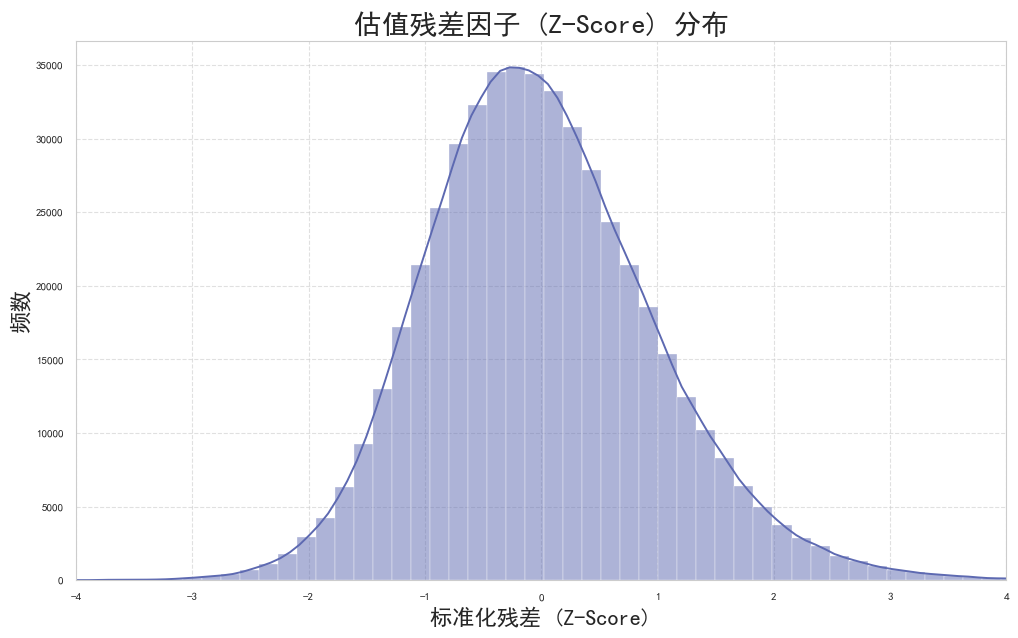


--- 步骤 4: 绘制残差分组与收益率关系图 ---
残差-收益率关系(箱线图)已保存至: ch3_pics\residual_return_boxplot.png


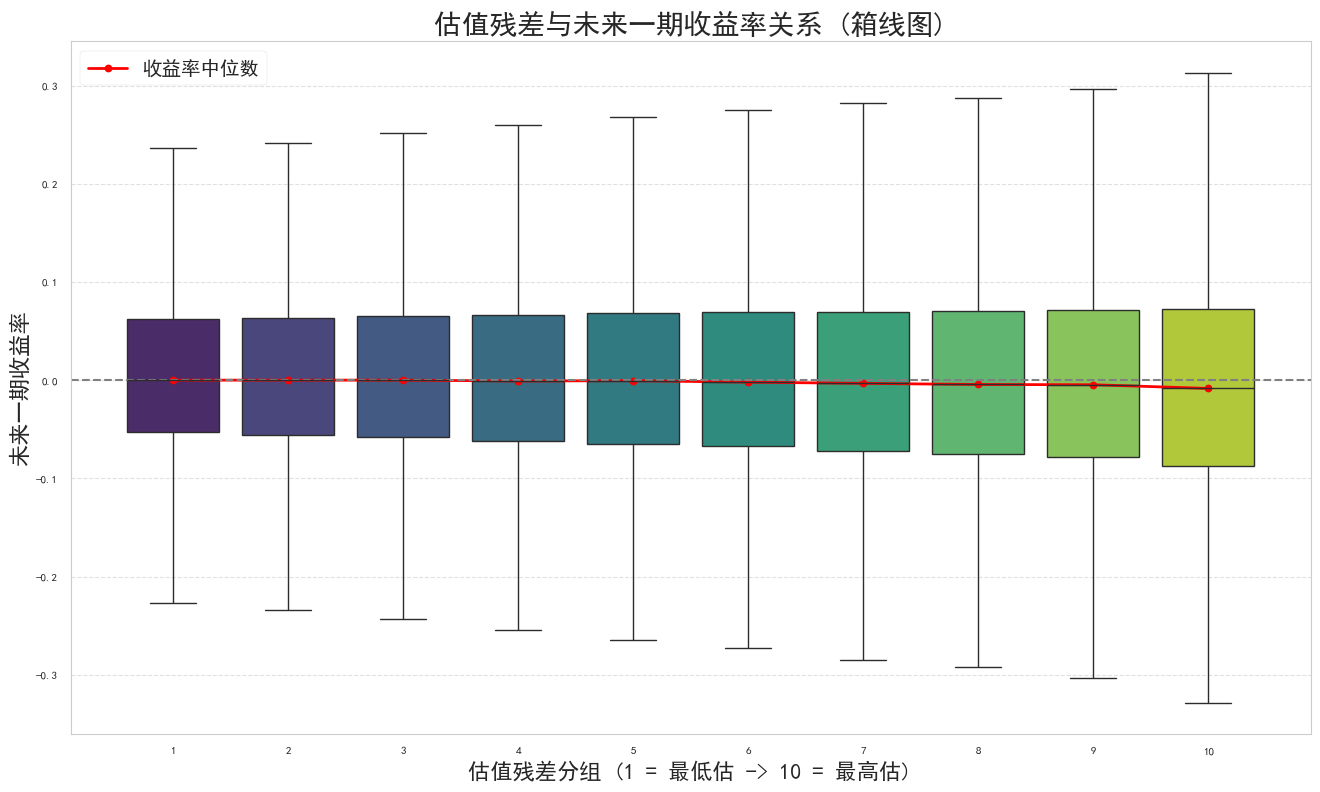


--- 步骤 5: 绘制残差分组与平均收益率关系柱状图 ---
残差-平均收益率关系(柱状图)已保存至: ch3_pics\residual_return_barplot.png


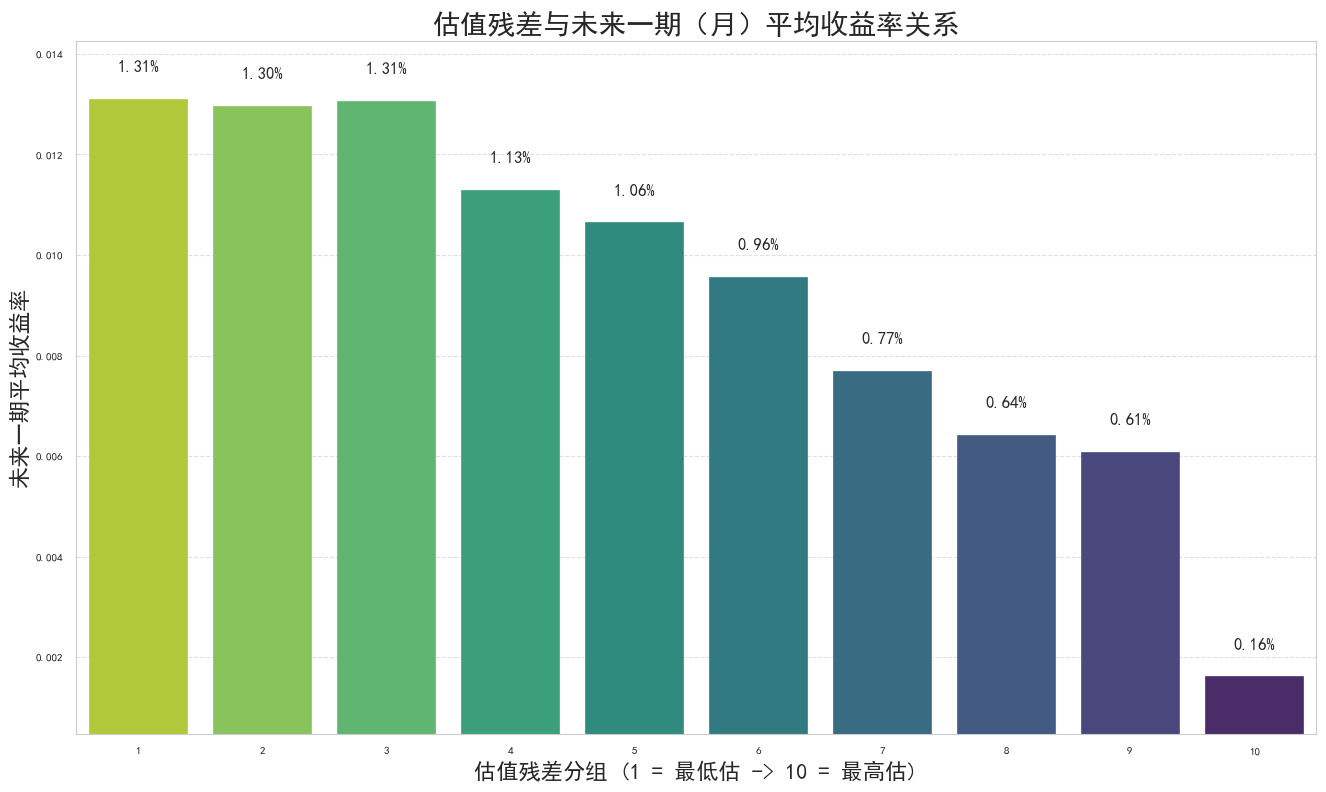

In [11]:
# 分析：残差分布
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
DATA_PATH = Path("E:/PBROE/data")
CH3_PATH = Path("E:/PBROE/ch3")

# 包含残差数据的文件 (由 pbroe3.1 脚本生成)
RESIDUAL_FILE = CH3_PATH / 'pbroe3.1.csv'
# 包含月度收益率数据的文件
RETURNS_FILE = DATA_PATH / 'TRDNEW_Mnth.csv'

# --- 输出配置 ---
output_dir = Path("./ch3_pics")
output_dir.mkdir(exist_ok=True)

# =================================================================== #
#                           【2. 绘图风格设置】                       #
# =================================================================== #

def set_academic_style():
    """设置图表的学术风格"""
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams['font.size'] = 18

set_academic_style()

# =================================================================== #
#                       【3. 数据加载与合并】                         #
# =================================================================== #
print("--- 步骤 1: 加载残差数据和收益率数据 ---")

try:
    # 加载残差数据
    df_residual = pd.read_csv(RESIDUAL_FILE)
    df_residual['调入日期'] = pd.to_datetime(df_residual['调入日期'])
    # 【已修复】统一 stkcd 的数据类型为补零的字符串
    df_residual['stkcd'] = df_residual['stkcd'].astype(str).str.zfill(6)
    print(f"成功加载 {len(df_residual)} 条残差数据。")

    # 加载收益率数据
    df_returns = pd.read_csv(RETURNS_FILE, usecols=['Stkcd', 'Trdmnt', 'Mretwd'])
    df_returns.rename(columns={'Stkcd': 'stkcd', 'Trdmnt': 'return_month', 'Mretwd': 'next_month_return'}, inplace=True)
    df_returns['stkcd'] = df_returns['stkcd'].astype(str).str.zfill(6)
    df_returns['return_month'] = pd.to_datetime(df_returns['return_month'])
    df_returns['next_month_return'] = pd.to_numeric(df_returns['next_month_return'], errors='coerce')
    print(f"成功加载 {len(df_returns)} 条收益率数据。")

except FileNotFoundError as e:
    print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
    # 如果文件不存在，则退出
    exit()

print("\n--- 步骤 2: 合并数据，将 T 期的残差与 T+1 期的收益率对齐 ---")

# 在残差表中，'调入日期' 是 T+1 月的月初，我们需要用它来匹配 T+1 月的收益
# 我们将 '调入日期' 转换为 'YYYY-MM' 格式作为匹配键
df_residual['merge_key'] = df_residual['调入日期'].dt.strftime('%Y-%m')
df_returns['merge_key'] = df_returns['return_month'].dt.strftime('%Y-%m')

# 合并数据
df_analysis = pd.merge(
    df_residual,
    df_returns[['stkcd', 'merge_key', 'next_month_return']],
    on=['stkcd', 'merge_key'],
    how='left'
)

# 清除没有匹配到下期收益的数据
df_analysis.dropna(subset=['next_month_return'], inplace=True)

print(f"数据合并完成，共得到 {len(df_analysis)} 条有效的分析样本。")


# =================================================================== #
#                       【4. 残差分布直方图】                         #
# =================================================================== #
print("\n--- 步骤 3: 绘制残差分布直方图 ---")

plt.figure(figsize=(12, 7))
sns.histplot(df_analysis['residual_zscore'], bins=100, kde=True, color='#5D69B1')
plt.title('估值残差因子 (Z-Score) 分布', fontsize=20)
plt.xlabel('标准化残差 (Z-Score)', fontsize=16)
plt.ylabel('频数', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-4, 4) # 限制x轴范围，更好地观察核心分布

save_path = output_dir / 'residual_distribution_histogram.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"残差分布图已保存至: {save_path}")
plt.show()


# =================================================================== #
#                  【5. 残差分组与收益率关系图】                      #
# =================================================================== #
print("\n--- 步骤 4: 绘制残差分组与收益率关系图 ---")

# 对所有样本，按残差大小分为10组 (十分位)
df_analysis['residual_group'] = pd.qcut(df_analysis['residual_zscore'], 10, labels=False) + 1

# --- 图一：箱线图 (展示分布) ---
plt.figure(figsize=(16, 9))
sns.boxplot(x='residual_group', y='next_month_return', data=df_analysis, palette='viridis', showfliers=False)

# 计算并绘制每组的中位数连线
group_medians = df_analysis.groupby('residual_group')['next_month_return'].median()
plt.plot(group_medians.index - 1, group_medians.values, 'r-o', lw=2, label='收益率中位数')

plt.title('估值残差与未来一期收益率关系 (箱线图)', fontsize=20)
plt.xlabel('估值残差分组 (1 = 最低估 -> 10 = 最高估)', fontsize=16)
plt.ylabel('未来一期收益率', fontsize=16)
plt.axhline(0, color='grey', linestyle='--', lw=1.5)

plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

save_path_box = output_dir / 'residual_return_boxplot.png'
plt.savefig(save_path_box, dpi=300, bbox_inches='tight')
print(f"残差-收益率关系(箱线图)已保存至: {save_path_box}")
plt.show()


# --- 【新增】图二：柱状图 (展示均值) ---
print("\n--- 步骤 5: 绘制残差分组与平均收益率关系柱状图 ---")

# 计算每组的平均收益率
group_means = df_analysis.groupby('residual_group')['next_month_return'].mean()

plt.figure(figsize=(16, 9))
bar_plot = sns.barplot(x=group_means.index, y=group_means.values, palette='viridis_r') # 使用反色系

# 添加数据标签
for index, value in enumerate(group_means):
    plt.text(index, value + 0.0005 * np.sign(value), f'{value:.2%}',
             ha='center', va='bottom' if value >= 0 else 'top', fontsize=12)

plt.title('估值残差与未来一期（月）平均收益率关系', fontsize=20)
plt.xlabel('估值残差分组 (1 = 最低估 -> 10 = 最高估)', fontsize=16)
plt.ylabel('未来一期平均收益率', fontsize=16)
plt.axhline(0, color='grey', linestyle='--', lw=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 调整y轴范围以更好地显示标签
min_y, max_y = group_means.min(), group_means.max()
padding = (max_y - min_y) * 0.1
plt.ylim(min_y - padding, max_y + padding)

save_path_bar = output_dir / 'residual_return_barplot.png'
plt.savefig(save_path_bar, dpi=300, bbox_inches='tight')
print(f"残差-平均收益率关系(柱状图)已保存至: {save_path_bar}")
plt.show()
